In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# 1. Choose Dataset (California Housing)
print("Loading Dataset...")
data = fetch_california_housing(as_frame=True)
df = data.frame

Loading Dataset...


In [3]:
# ---------------------------------------------------------
# 2. Feature Engineering
# ---------------------------------------------------------

# A. Create a Categorical Feature to demonstrate One-Hot Encoding
# (The dataset is numeric, so we create a 'Location_Zone' based on Latitude)
df['Location_Zone'] = pd.cut(df['Latitude'], bins=3, labels=['South', 'Central', 'North'])

# Define features
numeric_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude']
categorical_features = ['Location_Zone']

X = df[numeric_features + categorical_features]
y = df['MedHouseVal']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# B. Build Preprocessing Pipeline
# - Numeric: Standard Scaling -> Polynomial Features (includes Interaction terms)
# - Categorical: One-Hot Encoding
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)) # Adds interaction terms automatically
])

categorical_transformer = OneHotEncoder(drop='first') # Drops one column to avoid dummy variable trap

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [4]:
# ---------------------------------------------------------
# 3. Train Models: Linear, Ridge, Lasso, ElasticNet
# ---------------------------------------------------------

models = {
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=10),
    "Lasso (L1)": Lasso(alpha=0.005, max_iter=10000), # Low alpha to see shrinking, not zeroing everything
    "ElasticNet": ElasticNet(alpha=0.005, l1_ratio=0.5)
}

results = {}
coefficients = {}

print("\nTraining Models & Comparing Performance...")
print("-" * 60)
print(f"{'Model':<20} | {'Train MSE':<10} | {'Test MSE':<10} | {'Test R2 Score'}")
print("-" * 60)

for name, model in models.items():
    # Create full pipeline: Preprocessing -> Model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])

    clf.fit(X_train, y_train)

    # Predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    results[name] = {'Train MSE': train_mse, 'Test MSE': test_mse, 'R2': r2}

    print(f"{name:<20} | {train_mse:.4f}     | {test_mse:.4f}     | {r2:.4f}")

    # Extract coefficients for visualization
    if hasattr(clf.named_steps['model'], 'coef_'):
        coefficients[name] = clf.named_steps['model'].coef_


Training Models & Comparing Performance...
------------------------------------------------------------
Model                | Train MSE  | Test MSE   | Test R2 Score
------------------------------------------------------------
Linear Regression    | 0.4872     | 0.5120     | 0.6093
Ridge (L2)           | 0.4874     | 0.5168     | 0.6056


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.761e+01, tolerance: 2.207e+00
  model = cd_fast.enet_coordinate_descent(


Lasso (L1)           | 0.5068     | 0.6814     | 0.4800
ElasticNet           | 0.4973     | 0.5966     | 0.5447


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.177e+02, tolerance: 2.207e+00
  model = cd_fast.enet_coordinate_descent(


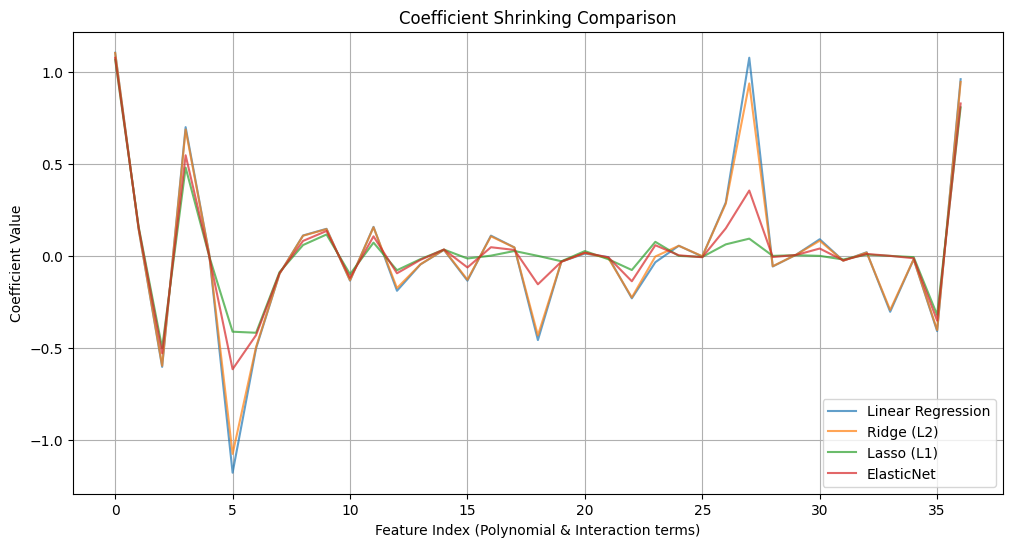

In [5]:
# ---------------------------------------------------------
# 4. Compare Overfitting & Coefficient Shrinking (Visualization)
# ---------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.title("Coefficient Shrinking Comparison")
for name, coefs in coefficients.items():
    plt.plot(coefs, alpha=0.7, label=name)
plt.xlabel("Feature Index (Polynomial & Interaction terms)")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(True)
plt.show()